In [1]:
# Imports required libraries
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import pickle

In [2]:
# Reading the dataset
dataset = []
with open("LabeledDataSet.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      label = row[2]
      sentence = row[1]
      item = []
      item.append(sentence)
      if label == '0': # introduction
        item.append(0)
      elif label == '1': # past experience
        item.append(1)
      elif label == '2': # mentioned skills
        item.append(2)
      elif label == '3': # questions/requests
        item.append(3)
      else:
        continue  
      dataset.append(item)
# Seperate into sentences and labels
sentences=[]
labels=[]
random.shuffle(dataset)
for x in range(len(dataset)):
    sentences.append(dataset[x][0])
    labels.append(dataset[x][1])
    


In [3]:
# Inspecting the data
print(pd.DataFrame({'sentence' : sentences[0:10], 'label':labels[0:10]}))

                                            sentence  label
0  Conducting in-depth data mining, visualization...      1
1                                           friendly      0
2  I was also able to increase my expertise in Ja...      2
3  Last year I worked at name of past Internship ...      1
4  I came across the opening for Software Develop...      1
5  JAD sessions, Brain Storming sessions, Worksho...      2
6  I was given the responsibility for working on ...      1
7  On a personal level I have the ability to stay...      2
8        Extensive knowledge of agile methodologies.      2
9  I am improving my knowledge in the field of pr...      0


In [4]:
# Splitting the dataset into Train and Evaluation
training_sentences = sentences[0:1088]
training_labels = labels[0:1088]
evaluation_sentences = sentences[1088:]
evaluation_labels = labels[1088:]

In [5]:
# Preprocessing 

# Setting the model parameters
embedding_dim = 300

# Setting the padding properties
max_length = 50
trunc_type='post'
padding_type='post'

oov_tok = "<OOV>"
training_size=1088
test_portion=.1

# Fit the tokenizer on Training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

# Creating padded sequences from train and test data
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)

In [6]:
# Splitting the dataset into training and validation 
split = int(test_portion * training_size)
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = training_labels[0:split]
training_labels = training_labels[split:training_size]

In [7]:
#loading the pre-trained FastText word embedding in English
import fasttext
import fasttext.util
ft = fasttext.load_model('cc.en.300.bin')
ft.get_dimension()

300

In [8]:
# Mapping FastText word vectors with word in the dataset 
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [9]:
#Training the model Classifire using the LSTM algorithm
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, 
                              input_length=max_length, weights=[embeddings_matrix], 
                              trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Training the model
num_epochs = 10

# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=2)
print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           887100    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,106,877
Trainable params: 219,777
Non-trainable params: 887,100
_________________________________________________________________
Train on 980 samples, validate on 108 samples
Epoch 1/10
980/980 - 11s - loss: -5.8683e-01 - accuracy: 0.3918 - val_loss: -3.7665e+00 - val_accuracy: 0.4167
Epoch 2/10
980/980 - 3s - loss: -2.3647e+00 - accuracy: 0.3929 - val_loss: -5.9668e+00 - val_accuracy: 0.4167
Epoch 3/10
980/980 - 3s - loss: -3.1868e+00 - accuracy: 0.3929 - val_loss: -7.1559e+00 - val_accuracy: 0.

In [10]:
# Plotting accuracies and errors
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

<Figure size 432x288 with 0 Axes>

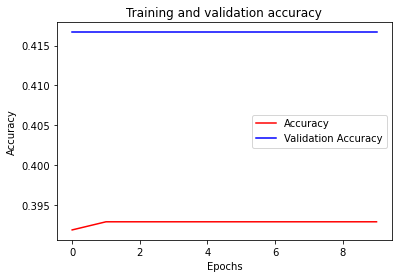

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()

<Figure size 432x288 with 0 Axes>

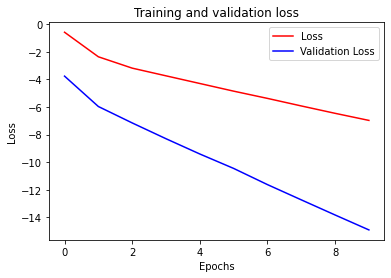

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.figure()

In [13]:
# Model Evaluation , final sanity check by using the model to predict two new sentences
eval_sequences = tokenizer.texts_to_sequences(evaluation_sentences)
eval_padded = pad_sequences(eval_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(eval_padded)
predicted_labels = []
for x in pred:
  predicted_labels.append(int(x.round().item()))

predicted_labels = tf.convert_to_tensor(predicted_labels)
from sklearn.metrics import classification_report
print(classification_report(evaluation_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.40      1.00      0.57       108
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        14

    accuracy                           0.40       272
   macro avg       0.10      0.25      0.14       272
weighted avg       0.16      0.40      0.23       272



C:\Users\LENOVO\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Testing model with sample text
def cl_Sentence(sentence):
  sentence_sequence = tokenizer.texts_to_sequences(sentence)
  padded_sentence_sequence = pad_sequences(sentence_sequence, 
                                       maxlen=max_length, padding=padding_type, 
                                       truncating=trunc_type)
  sentence_prediction = model.predict(padded_sentence_sequence)
  label = sentence_prediction.round().item()
  if label == 0:
    print("%s : Introduction" % sentence)
  elif label == 1:
    print("%s : Past Experience" % sentence)
  elif label == 2:
    print("%s : Mentioned Skills" % sentence)
  elif label == 3:
    print("%s : Questions" % sentence)
    
# Use sentence as input and will predict the label

cl_Sentence(['I am fluent in English'])
cl_Sentence(['I worked as a Back-end Developer at MobiOs Ltd. for more than 1 year.'])
cl_Sentence(['My name is Nimal and I am pleased to be applying for the Software Engineer job'])
cl_Sentence(['Can we arrange a face-to-face or telephone call'])

['I am fluent in English'] : Past Experience
['I worked as a Back-end Developer at MobiOs Ltd. for more than 1 year.'] : Past Experience
['My name is Nimal and I am pleased to be applying for the Software Engineer job'] : Past Experience
['Can we arrange a face-to-face or telephone call'] : Past Experience
